[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VaasuDevanS/kaggle-submissions/blob/main/Notebooks/02-dog-breed-identification.ipynb)

<h1>Dog Breed Identification</h1>

[https://www.kaggle.com/c/dog-breed-identification](https://www.kaggle.com/c/dog-breed-identification/)

Author: Vaasudevan Srinivasan [(Portfolio)](https://vaasudevans.github.io) <br>
Created on: July 06, 2021 <br>

# Download and unzip the Dataset

In [ ]:
%%capture
%%bash

pip install --upgrade --force-reinstall --no-deps kaggle
mkdir ~/.kaggle 
cp kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c dog-breed-identification
unzip -o dog-breed-identification -d data

# Import all the Modules

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import os

sns.set_theme()
tf.__version__

'2.5.0'

# Data Preparation

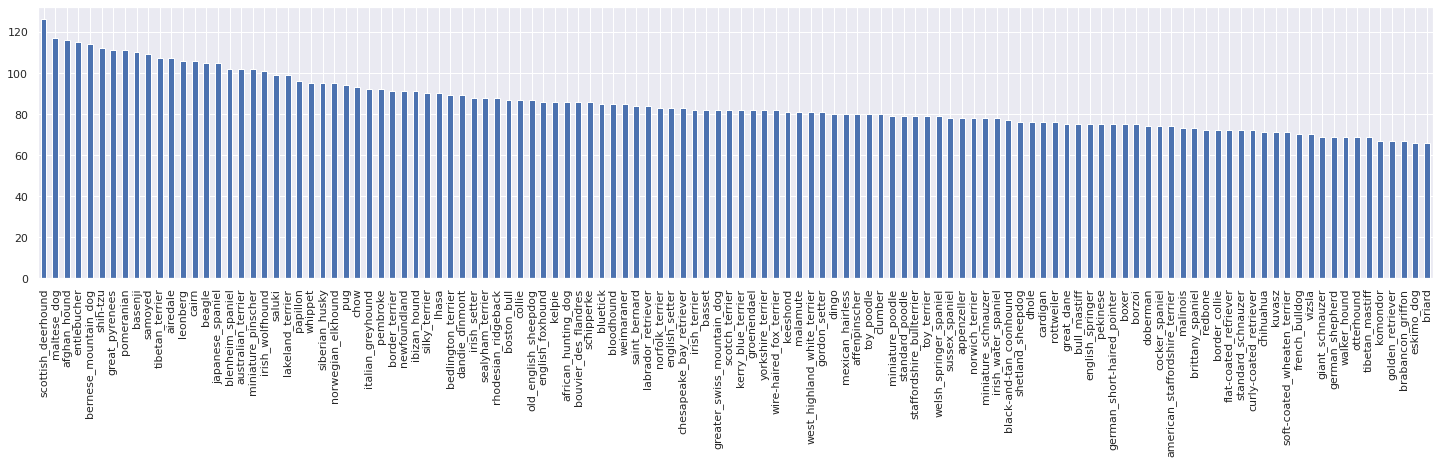

In [2]:
labels_df = pd.read_csv('data/labels.csv')
labels_df['id'] = labels_df['id'] + '.jpg'
labels_df.breed.value_counts().plot.bar(figsize=(25, 5));

In [3]:
datagen = ImageDataGenerator(rescale=1.0 / 255,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2,
                             validation_split=0.1)

train = datagen.flow_from_dataframe(labels_df,
                                    directory= 'data/train',
                                    x_col='id',
                                    y_col='breed',
                                    subset='training',
                                    target_size=(224, 224),
                                    batch_size=64,
                                    seed=123)

val = datagen.flow_from_dataframe(labels_df,
                                  directory= 'data/train',
                                  x_col='id',
                                  y_col='breed',
                                  subset='validation',
                                  target_size=(224, 224),
                                  batch_size=64,
                                  seed=123)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


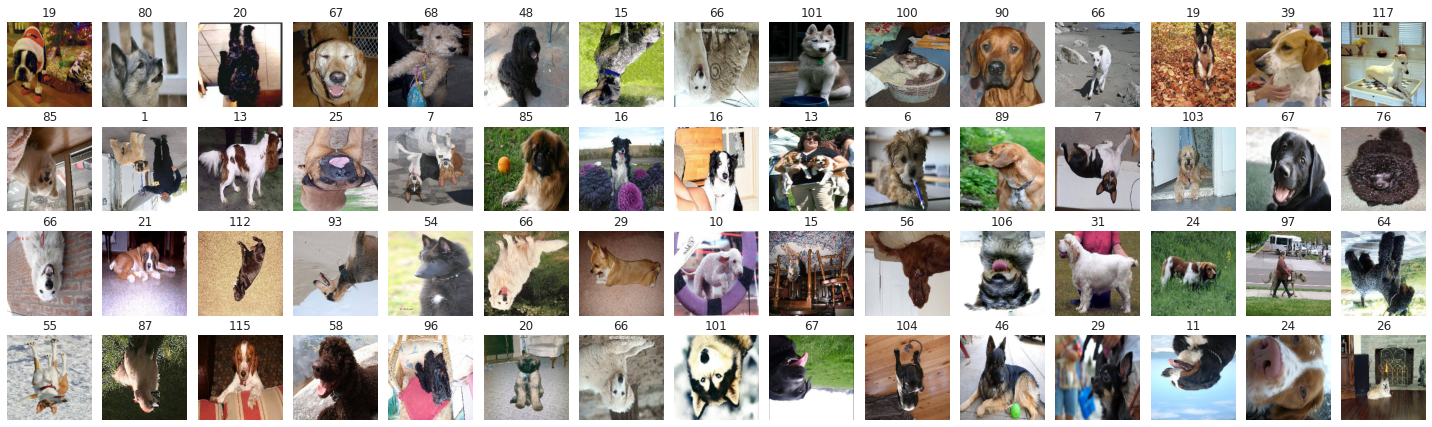

In [10]:
# Get the images from a val batch
imgs = val.next()
labels = list(val.class_indices.keys())

plt.figure(figsize=(20, 6))
cols, rows = 15, 4
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[0][i])
    plt.title(np.argmax(imgs[1][i]))
    plt.axis('off')

plt.tight_layout();

# Transfer Learning using Inception ResNet V2

In [4]:
inception_resnet_url = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5'
inception_resnet = tf.keras.Sequential([
    hub.KerasLayer(inception_resnet_url, trainable=False),
    tf.keras.layers.Dense(120, activation='softmax'),
])
inception_resnet.build((None, 224, 224, 3))
inception_resnet.compile(loss='categorical_crossentropy',
                         optimizer='adam', metrics=['accuracy'])
h = inception_resnet.fit(train, validation_data=val, epochs=10,
                         steps_per_epoch=len(train),
                         validation_steps=len(val))

Epoch 1/10
144/144 [==============================] - 145s 904ms/step - loss: 2.5270 - accuracy: 0.5030 - val_loss: 1.9245 - val_accuracy: 0.5900
Epoch 2/10
144/144 [==============================] - 124s 863ms/step - loss: 1.5149 - accuracy: 0.6439 - val_loss: 1.6980 - val_accuracy: 0.6057
Epoch 3/10
144/144 [==============================] - 125s 865ms/step - loss: 1.3224 - accuracy: 0.6710 - val_loss: 1.7414 - val_accuracy: 0.6194
Epoch 4/10
144/144 [==============================] - 124s 863ms/step - loss: 1.2006 - accuracy: 0.6891 - val_loss: 1.8277 - val_accuracy: 0.6213
Epoch 5/10
144/144 [==============================] - 125s 864ms/step - loss: 1.1213 - accuracy: 0.7075 - val_loss: 1.7077 - val_accuracy: 0.6311
Epoch 6/10
144/144 [==============================] - 125s 864ms/step - loss: 1.0782 - accuracy: 0.7102 - val_loss: 1.7203 - val_accuracy: 0.6331
Epoch 7/10
144/144 [==============================] - 125s 865ms/step - loss: 1.0193 - accuracy: 0.7282 - val_loss: 1.8472 -

# Prediction and Submission

In [5]:
test_df = pd.read_csv('data/sample_submission.csv')
breeds = test_df.columns[1:].tolist()
test_df['file_name'] = test_df['id'] + '.jpg'

In [6]:
test_gen = ImageDataGenerator(rescale=1.0 / 255)

test = test_gen.flow_from_dataframe(test_df,
                                    x_col='file_name',
                                    y_col=None,
                                    directory='data/test',
                                    class_mode=None,
                                    target=(224, 224))

Found 10357 validated image filenames.


In [7]:
# Predict
test_df.loc[:, breeds] = inception_resnet.predict(test)
test_df[breeds].head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000058,0.000004,0.000006,0.000054,0.000246,4.632110e-04,0.000011,0.000192,0.000206,0.000102,0.000128,1.037020e-05,0.000077,0.000032,0.000045,0.000007,0.000003,0.000001,0.000003,0.000390,0.000143,0.000142,0.000043,0.000020,5.060546e-06,0.000026,0.000064,0.000035,0.000007,0.005716,3.277383e-06,0.000013,8.139005e-05,3.109340e-07,2.898351e-07,0.000048,0.000057,0.000096,0.006180,0.000236,...,0.000002,0.000038,0.000007,5.855433e-07,2.869219e-04,0.000008,2.232500e-05,0.000052,0.000009,0.000131,0.000184,0.000004,0.000009,0.000376,0.000012,0.000445,0.001355,0.000007,0.000794,0.000018,0.000091,0.000032,4.387930e-05,9.627130e-07,0.000023,0.000239,0.000175,4.439192e-05,7.662603e-07,0.000003,1.455373e-04,0.402987,0.000498,0.000032,0.000011,1.478004e-05,0.000192,0.006472,0.009240,0.000339
1,0.000031,0.000030,0.000134,0.000028,0.000149,1.248753e-04,0.000334,0.000075,0.000038,0.000010,0.000004,8.425502e-08,0.973810,0.000014,0.000214,0.000206,0.000003,0.000180,0.000211,0.000030,0.000070,0.000013,0.000048,0.000002,1.745500e-07,0.000011,0.000001,0.000003,0.000158,0.000198,1.016655e-06,0.000007,2.001934e-07,4.113321e-06,2.005704e-05,0.000022,0.000009,0.000031,0.002693,0.000022,...,0.000002,0.000001,0.000040,5.373753e-04,6.454093e-07,0.000003,2.570275e-06,0.000128,0.000004,0.000361,0.000227,0.000997,0.000005,0.000023,0.000023,0.000209,0.000042,0.000006,0.000017,0.000015,0.000046,0.000003,3.141274e-07,4.621583e-06,0.000004,0.000001,0.000131,6.689692e-07,1.159880e-04,0.000002,8.161399e-07,0.003760,0.000033,0.000739,0.000016,5.078505e-07,0.000174,0.000117,0.000016,0.000017
2,0.000182,0.001263,0.000077,0.002418,0.002724,1.990767e-04,0.012397,0.000070,0.000055,0.000311,0.000040,3.521323e-05,0.000005,0.000042,0.000224,0.000016,0.003745,0.001760,0.003666,0.000021,0.000553,0.000021,0.000346,0.014872,9.961311e-05,0.010378,0.740453,0.000801,0.000015,0.005045,3.739079e-04,0.000011,5.410789e-04,3.804750e-04,1.615319e-05,0.000497,0.000051,0.000204,0.000013,0.000023,...,0.000035,0.011691,0.000993,1.563919e-03,4.742510e-04,0.004541,3.320684e-04,0.000841,0.000924,0.000041,0.001174,0.000229,0.000052,0.000066,0.000853,0.000685,0.013760,0.004728,0.000152,0.000441,0.009450,0.000158,6.583150e-03,2.482276e-03,0.000228,0.000243,0.000451,1.284025e-04,2.189369e-04,0.003598,1.051098e-03,0.001571,0.000050,0.000077,0.000006,4.049874e-04,0.008178,0.001270,0.003779,0.002741
3,0.000284,0.001102,0.000039,0.000248,0.000006,4.052730e-07,0.000095,0.000004,0.000004,0.000030,0.000491,4.583306e-07,0.000042,0.000006,0.000026,0.000003,0.000203,0.000063,0.000960,0.000094,0.000494,0.000084,0.000003,0.000299,5.625792e-06,0.000002,0.000180,0.000024,0.000037,0.000003,5.771055e-07,0.000011,5.118987e-06,1.552274e-06,4.830440e-05,0.000181,0.000001,0.000003,0.000013,0.000019,...,0.000031,0.000081,0.000045,1.739400e-03,1.232532e-05,0.000005,1.971972e-07,0.000022,0.000030,0.000001,0.000358,0.

In [8]:
test_df.drop('file_name', axis=1).to_csv('submission.csv', index=False)

In [9]:
!kaggle competitions submit -c dog-breed-identification -f submission.csv -m "Transfer Learning using Inception ResNet V2"

100% 26.6M/26.6M [00:00<00:00, 46.9MB/s]
Successfully submitted to Dog Breed Identification